# Data Analysis Notebook

In [1]:
import json
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from pathlib import Path
from preprocessing import *

In [2]:
path_config = Path("config.json")
with(open(path_config, 'r')) as file:
    config = json.load(file)
    
catch_id = config['features']['catch_id']
target_col = config['features']['target_col']

In [3]:
df = read_df(config['data_path'], config['input']['train'])

In [4]:
df.head()

browser       date gender locale      location          os  \
37698  Firefox 2016-01-15      m  ru_RU  France/Paris  Windows 10   
5794   Firefox 2016-01-16      m  ru_RU  France/Paris      Ubuntu   
6692    Chrome 2016-01-18      m  ru_RU  France/Paris  Windows 10   
18746  Firefox 2016-01-19      m  ru_RU  France/Paris      Ubuntu   
48287   Chrome 2016-01-21      m  ru_RU  France/Paris      Ubuntu   

                                                   sites      time  user_id  
37698  [{'site': 'mail.google.com', 'length': 91}, {'...  11:07:00        0  
5794   [{'site': 'mail.google.com', 'length': 367}, {...  19:45:00        0  
6692   [{'site': 'mail.google.com', 'length': 40}, {'...  19:05:00        0  
18746  [{'site': 'mail.google.com', 'length': 304}, {...  20:14:00        0  
48287  [{'site': 'mail.google.com', 'length': 103}, {...  11:35:00        0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 37698 to 8753
Data columns (total 9 columns):
browser     80000 non-null object
date        80000 non-null datetime64[ns]
gender      80000 non-null object
locale      80000 non-null object
location    80000 non-null object
os          80000 non-null object
sites       80000 non-null object
time        80000 non-null object
user_id     80000 non-null int64
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 6.1+ MB


## Preprocessing locale and location columns

In [6]:
for col in config['features']['col_to_split']:
    if col =='locale':          
        df = split_col_by_delimiter(df=df, 
                                col_to_split=col, 
                                left_postfix='lang', 
                                right_postfix='country',
                                delimiter='-',
                                replace_sym='_'
                               )
    if col =='location':          
        df = split_col_by_delimiter(df=df, 
                                col_to_split=col, 
                                left_postfix='country', 
                                right_postfix='city',
                                delimiter='/',
                                replace_sym=None
                               )

## Visualisation

In [7]:
print(f"Catch user row count {df[df[target_col]==catch_id][target_col].count()}")
print(f"Other users row count {df[df[target_col]!=catch_id][target_col].count()}")
print(f"All users row count {df[target_col].count()}")
print(f"Percsntage of catch user row {df[df[target_col]==catch_id][target_col].count() * 100 / df[target_col].count()} %")
print(f"Unique users {len(np.unique(df[target_col].tolist()))}")

Catch user row count 400
Other users row count 79600
All users row count 80000
Percsntage of catch user row 0.5 %
Unique users 200


In [8]:
def build_bar_group_plot(df, catch_id, group_col, key_col='user_id'):
    df_gender_catch = df[df[key_col]==catch_id][[key_col, group_col]].groupby(group_col).count().reset_index()
    df_gender_others = df[df[key_col]!=catch_id][[key_col,group_col]].groupby(group_col).count().reset_index()
    fig = go.Figure()
    fig.add_trace(go.Bar(
        y=df_gender_catch[key_col],
        x=df_gender_catch[group_col],
        name='Catch User'
    ))
    fig.add_trace(go.Bar(
        y=df_gender_others[key_col],
        x=df_gender_others[group_col],
        name='Other Users'
    ))

    fig.update_layout(barmode='group',
                     title=f'{group_col}')
    fig.show()

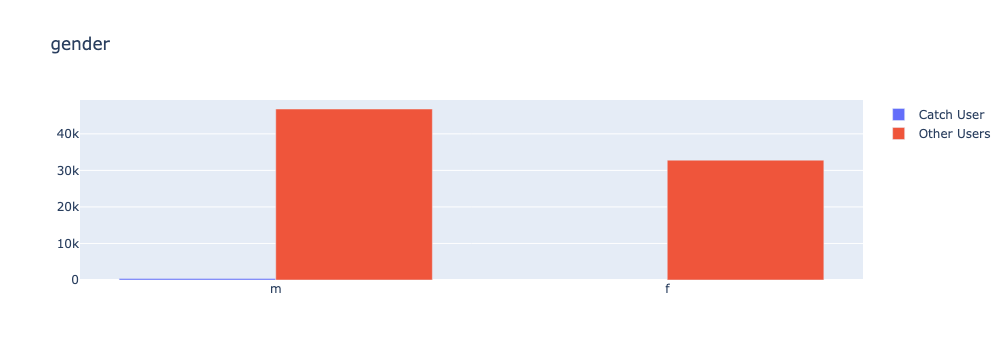

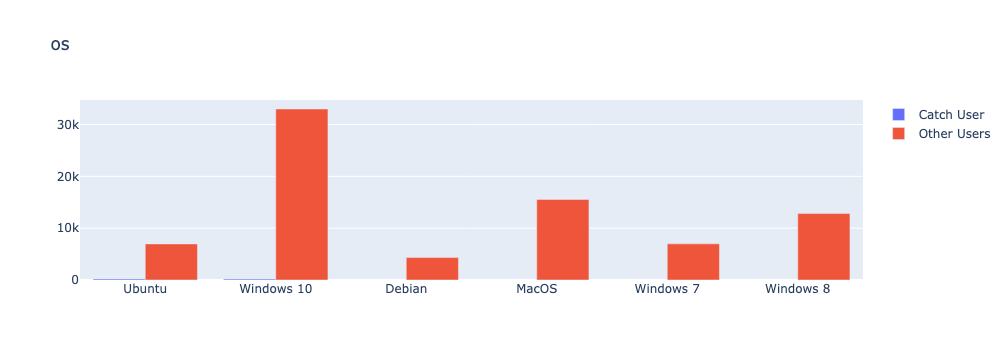

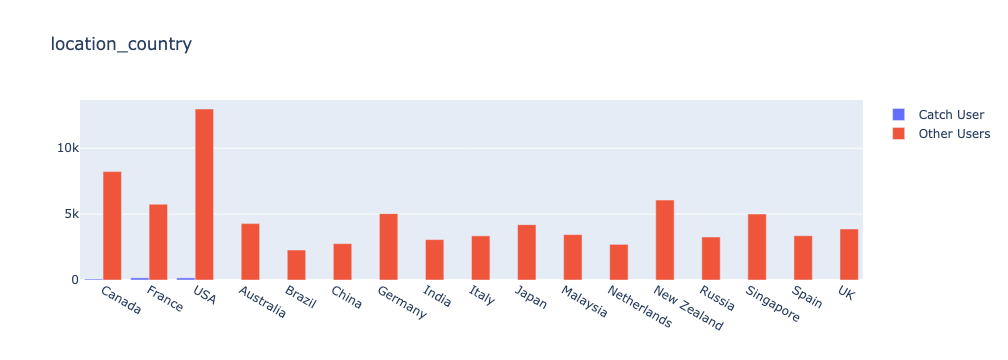

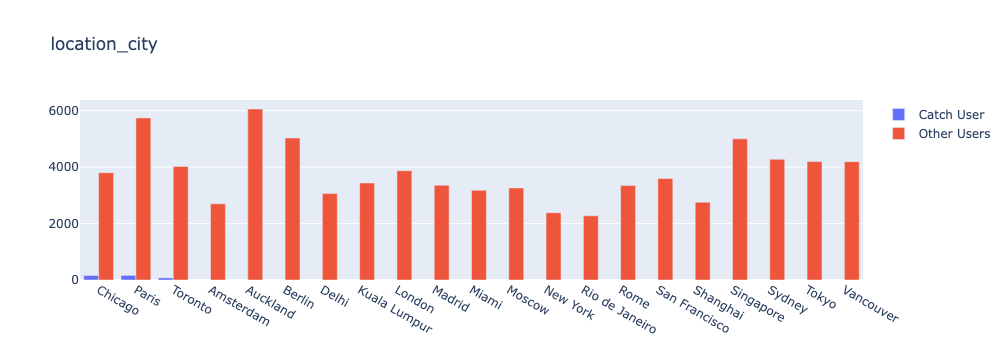

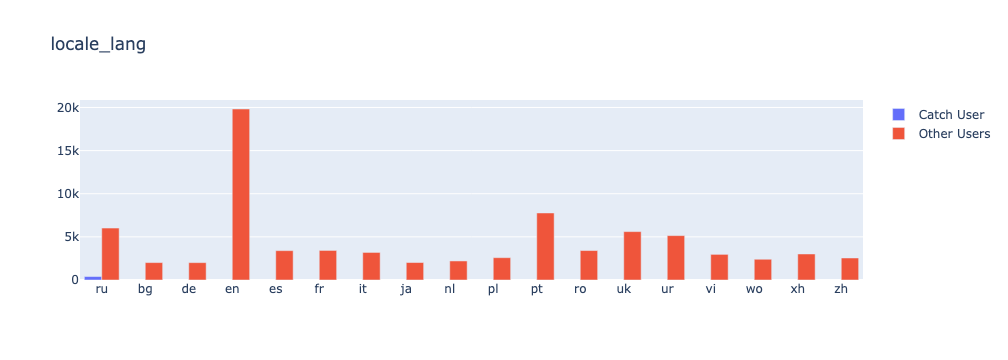

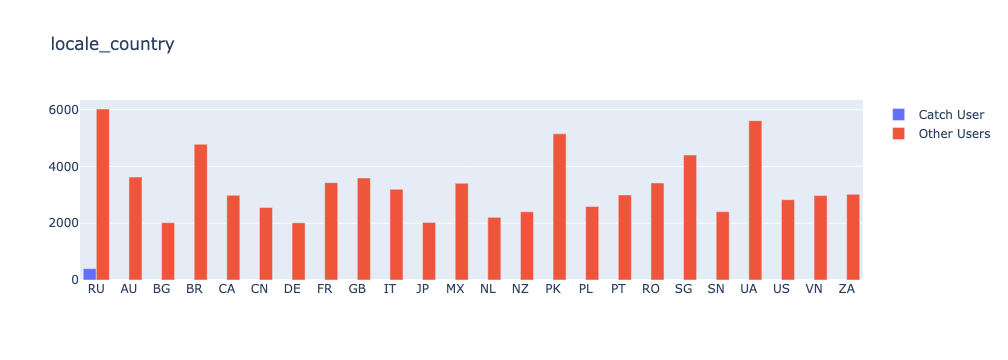

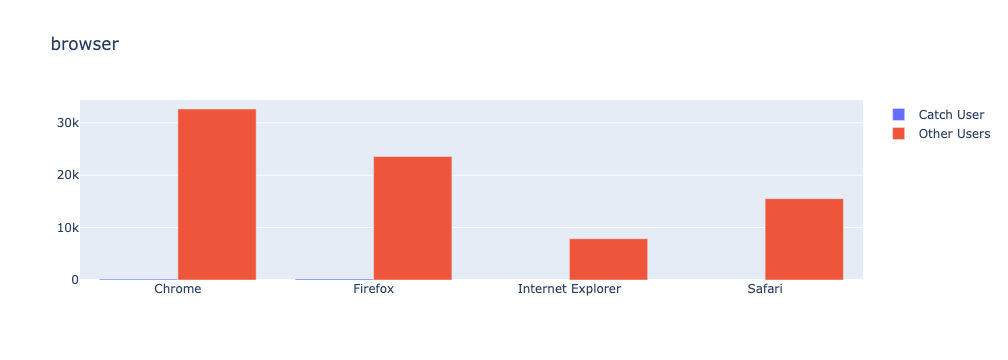

In [9]:
cols_to_plot = ['gender', 'os', 'location_country', 'location_city', 'locale_lang', 'locale_country', 'browser']
for col in cols_to_plot:
    build_bar_group_plot(df=df, catch_id=catch_id, group_col=col)

## Conclusions
The class disbalance is extremely huge

Our catch user is logging only as **male**

He is alwasys using **RU** locale from **RU** country locale

The user might log in from **Windows 10** or **Ubuntu**

The countries which have been used are **Canada**, **France**, **USA**

The cities which have been used are **Toronto**, **Paris**, **Chicago**

The browsers are **Chrome** and **Firefox**

## Expanding site column

In [10]:
for col in config['features']['col_to_expand']:
    df = expand_json_col_to_rows(df=df, col_to_expand=col)

In [11]:
df.sort_values([target_col,'date'],inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601630 entries, 37698 to 8753
Data columns (total 12 columns):
browser             601630 non-null object
date                601630 non-null datetime64[ns]
gender              601630 non-null object
os                  601630 non-null object
time                601630 non-null object
user_id             601630 non-null int64
locale_lang         601630 non-null object
locale_country      601630 non-null object
location_country    601630 non-null object
location_city       601630 non-null object
site                601630 non-null object
length              601630 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 59.7+ MB


In [13]:
df.head()

browser       date gender          os      time  user_id locale_lang  \
37698  Firefox 2016-01-15      m  Windows 10  11:07:00        0          ru   
37698  Firefox 2016-01-15      m  Windows 10  11:07:00        0          ru   
37698  Firefox 2016-01-15      m  Windows 10  11:07:00        0          ru   
5794   Firefox 2016-01-16      m      Ubuntu  19:45:00        0          ru   
5794   Firefox 2016-01-16      m      Ubuntu  19:45:00        0          ru   

      locale_country location_country location_city          site  length  
37698             RU           France         Paris    disqus.com   212.0  
37698             RU           France         Paris      live.com    50.0  
37698             RU           France         Paris  grepcode.com   238.0  
5794              RU           France         Paris    disqus.com    81.0  
5794              RU           France         Paris     vimeo.com   119.0

In [15]:
def build_world_cloud(df, word_col='site', weights_col='length', normalize_fonts=500, plot_width=1000, plot_height=800):
    import random
    len_cloud = len(df[word_col].tolist())
    words = df[word_col].tolist()
    colors = [px.colors.DEFAULT_PLOTLY_COLORS[random.randrange(1, 10)] for i in range(len_cloud)]
    weights = df[weights_col].tolist()
    weights = list(map(lambda x: x/normalize_fonts, weights))

    fig = go.Figure(go.Scatter(x=[random.randint(30, 60)/100 for i in range(len_cloud)],
                     y=[random.randint(30, 60)/100 for i in range(len_cloud)],
                     mode='text',
                     text=words,
                     marker={'opacity': 0.3},
                     textfont={'size': weights,
                               'color': colors}) 
                   )
    fig.update_layout(go.Layout({'xaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
                        'yaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False}}),
                     autosize=False,
                     width=plot_width,
                     height=plot_height)

    fig.show()
    
def get_dataset_for_cloud(df_cloud, catch_user, catch_id, top_to_get=50):
    
    if catch_user:
        df_cloud_catch = df_cloud[df_cloud[target_col]== catch_id].drop(target_col,axis=1)
    else:
        df_cloud_catch = df_cloud[df_cloud[target_col]!= catch_id].drop(target_col,axis=1)
    
    df_cloud_catch = df_cloud_catch.groupby('site').sum().reset_index()
    df_cloud_catch.sort_values('length', inplace=True, ascending=False)
    df_cloud_catch = df_cloud_catch[:top_to_get]
    return df_cloud_catch

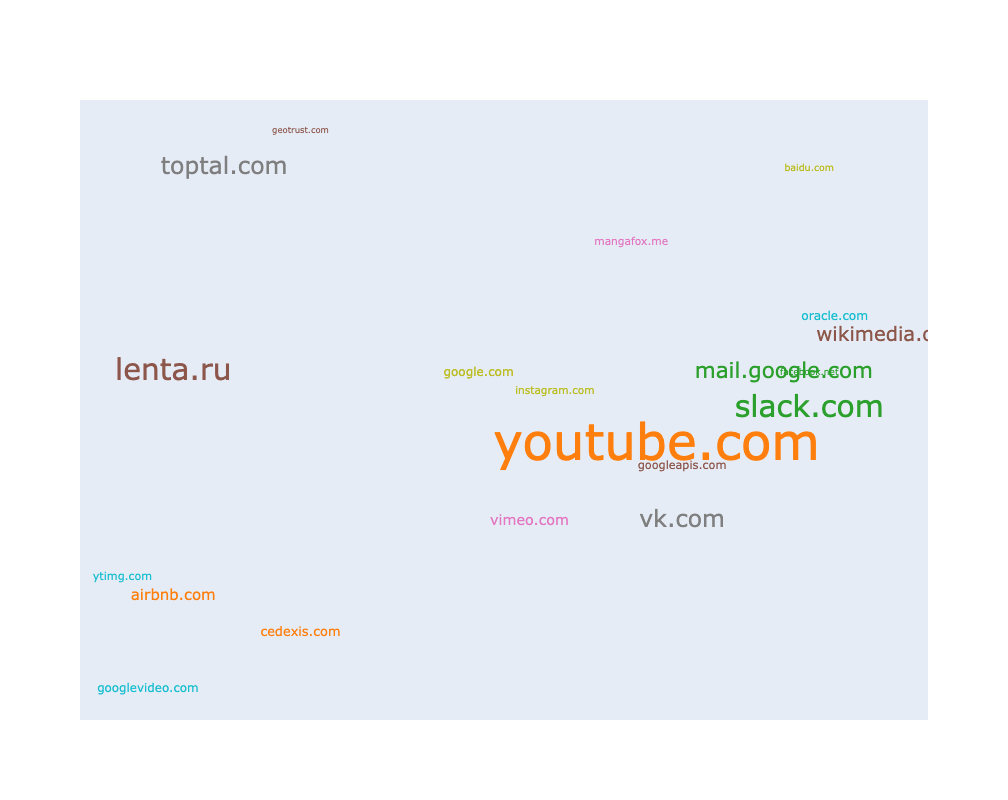

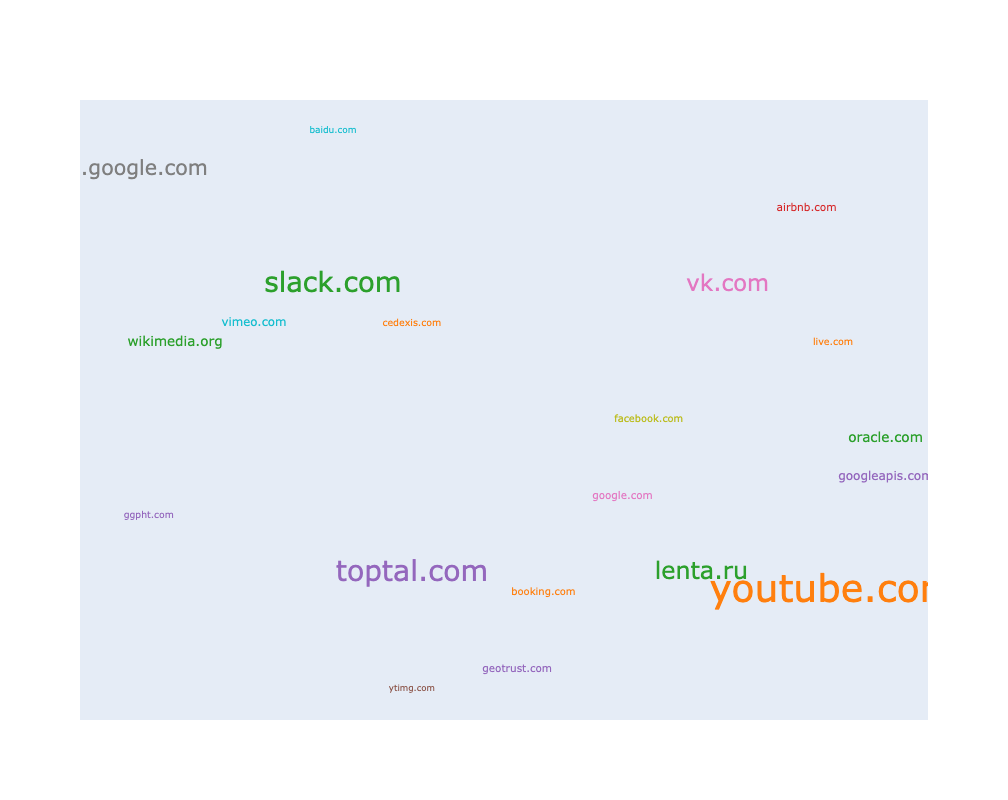

In [16]:
df_cloud_catch = get_dataset_for_cloud(df_cloud=df, catch_user=True, catch_id=catch_id, top_to_get=20)
df_cloud_others = get_dataset_for_cloud(df_cloud=df, catch_user=False, catch_id=catch_id, top_to_get=20)

build_world_cloud(df_cloud_catch, normalize_fonts=500)
build_world_cloud(df_cloud_others, normalize_fonts=100000)

## Conclusions

The NaN values for the site column were founded and will be replaced by mean values.

The most popular sites for catch user are quite similar to other users.

There are **youtube.com**, **lenta.ru**, **mail.google.com**, **vk.com**, **wikimedia.org**

In [17]:
def build_line_plot(df, catch_id, group_col, plot_col, key_col='user_id', normalize=True):
    df_gender_catch = df[df[key_col]==catch_id].groupby(group_col).sum().reset_index()
    df_gender_others = df[df[key_col]!=catch_id].groupby(group_col).sum().reset_index()
    
    if normalize:
        df_gender_catch[plot_col] = df_gender_catch[plot_col] / max(df_gender_catch[plot_col])
        df_gender_others[plot_col] = df_gender_others[plot_col] / max(df_gender_others[plot_col])
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        y=df_gender_catch[plot_col],
        x=df_gender_catch[group_col],
        name='Catch User'
    ))
    fig.add_trace(go.Scatter(
        y=df_gender_others[plot_col],
        x=df_gender_others[group_col],
        name='Other Users'
    ))

    fig.update_layout(title=f'{plot_col}')
    fig.show()

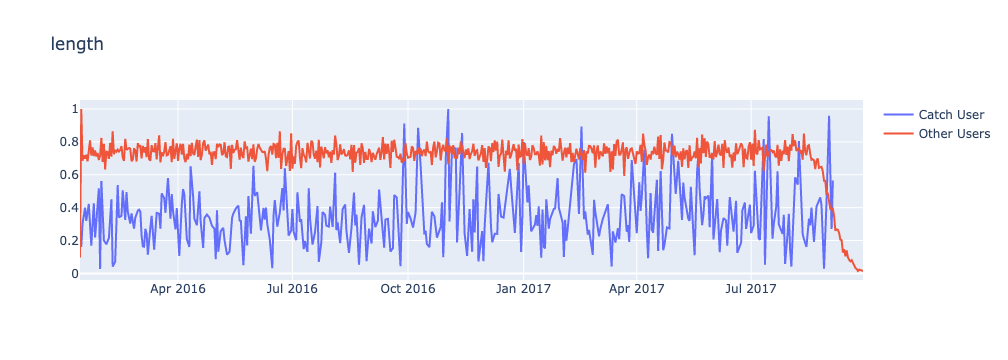

In [18]:
build_line_plot(df=df, catch_id=catch_id, group_col='date', plot_col='length')

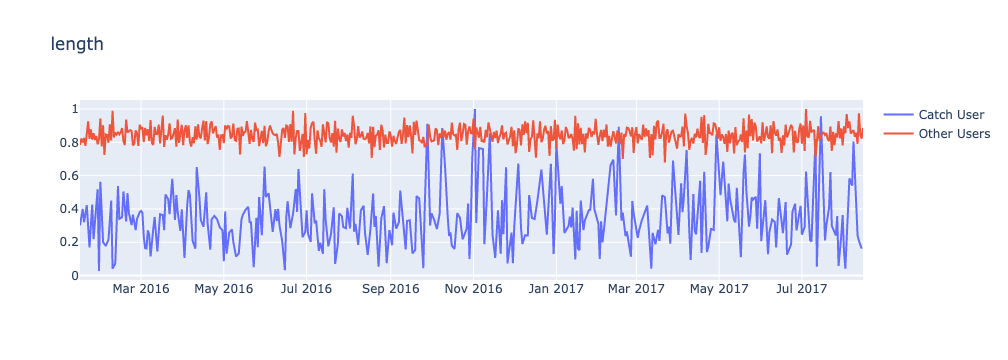

In [19]:
build_line_plot(df=df[(df['date']>config['features']['exclude_dates']['exclude_before']) & 
                      (df['date']<config['features']['exclude_dates']['exclude_after'])], 
                catch_id=catch_id, group_col='date', plot_col='length')

## Conclusions

The data before '2016-01-16' and after '2017-08-16' looks like outliers and have to be excluded before training

There is no strong weekly or monthly seasonality for users

In [20]:
df = convert_categorical_cols(df, config['features']['categorical_columns'])

In [21]:
df = extract_date_features(df, config['features']['date_features'])

In [22]:
df = extract_time_features(df, config['features']['time_features'])

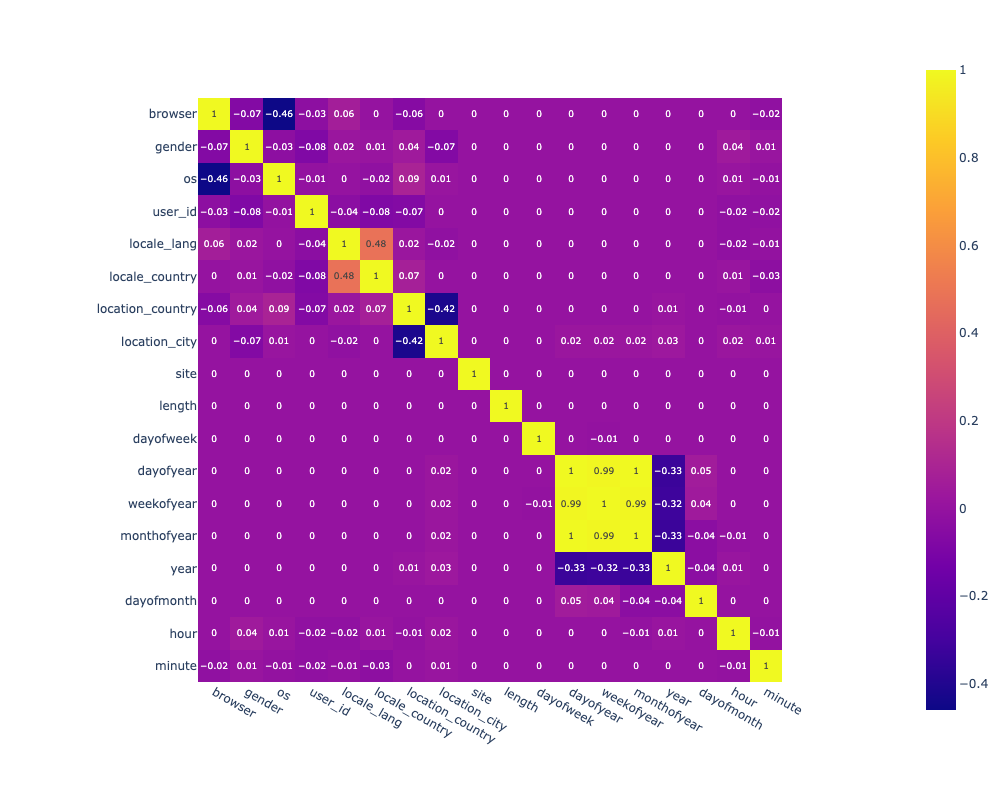

In [23]:
fig = px.imshow(df.corr().round(2), text_auto=True)
fig.update_layout(
    autosize=False,
    width=800,
    height=800)
fig.show()

## Conclusions 
No significant linear dependency between features has been found except for date features which were created